In [1]:
import torch
from torch.autograd import Variable
from functorch import vmap
import matplotlib.pylab as plt
import numpy as np
import scipy.stats as ss

import random

This code applies variational inference based on time-dependent OU processes to the observations drawn from the double well system SDE, as defined below. Note that we have chosen observational noise, i.e. variance of Gaussian noise and SDE variance to be 0.04 and 0.8 repectively. While the former is equal to the paramterization considered in Archambeau et al 2007, the latter is higher (0.8 vs 0.5)

Noisy Observations from the SDE:

$dX_{t} = 4X_{t}(1-X^{2}_{t})dt + \sigma dW_{t}$

**Generate observations from Gaussian likelihood**

In [15]:
# Time step the SDE: dot X = -mu X + sigma xi, by Euler's method.

# Problem setup. 
# Set model and numerical parameters, and the initial condition.
# These are the lines the user might want to vary.
tf = 8
Nsteps = 800
Npaths = 1
X0 = 1
sde_sigma = 0.8 # Variance is higher than the original example
obs_sigma = 0.04

# Generate the time grid and solution array
t, dt = np.linspace(0,tf,Nsteps+1,retstep=True)
X = np.zeros((Nsteps+1,Npaths))
root_dt = np.sqrt(dt)
  
# Time step starting from initial condition
X[0,:] = X0;
for n in range(Nsteps):
    F_of_X = 4 * X[n,:] * (1 - (X[n,:] ** 2))
    X[n+1,:] =  X[n,:] + dt * F_of_X + sde_sigma * root_dt * np.random.randn(Npaths)

# Observations with Gaussian noise
obs = np.random.normal(loc = X[::100], scale = obs_sigma)
obs_time = t[::100]

Change dtype

In [16]:
true_sde_pts = torch.from_numpy(t)
true_sde_trj = torch.from_numpy(X.flatten())

In [17]:
obs = torch.from_numpy(obs)
obs_time = torch.from_numpy(obs_time)

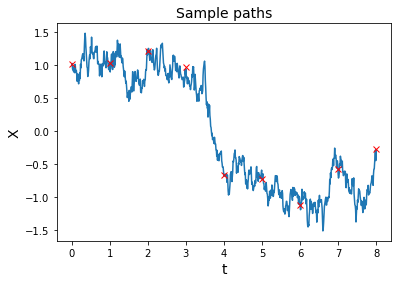

In [18]:
# Plot paths
plt.plot(t,X)
plt.plot(t[::100], obs, "rx")
plt.xlabel("t", fontsize=14)
plt.ylabel("X", fontsize=14)
plt.title("Sample paths", fontsize=14)
plt.show()


In [19]:
class OU:
    def __init__(self, t0, t1, z0, alpha, beta, sigma, dN):
        self.t0 = t0
        self.t1 = t1
        self.z0 = z0
        self.alpha = alpha
        self.beta = beta
        self.sigma = sigma
        self.pts = torch.sort(torch.cat([torch.DoubleTensor(dN-2).uniform_(t0,t1), torch.tensor([self.t0, self.t1])]))[0]
        self.trj, self.dt = self.simulate()
        
    def simulate(self):
        """
            Simulate an OU process on a set of discrete points
        """
        output = np.empty(len(self.pts))
        output[0] = self.z0
        interval = self.pts[1:] - self.pts[:-1]
        for t in range(1, len(self.pts)):
            
            # if the distance is too small, variance becomes 0
            dt = interval[t-1]
            
            mean = self.alpha + (output[t-1] - self.alpha) * np.exp(-1 * self.beta * dt)
            var = np.sqrt((self.sigma ** 2) * (1 - np.exp(-2 * self.beta * dt)) / (2 * self.beta))
            assert var > 0, "variance is negative, var:%.3f interval: %.3f" % (var, dt)
            output[t] = ss.norm.rvs(loc = mean, scale = var)
        return torch.from_numpy(output), interval

**Class: OU processes**

In [20]:
class tOU_vector:
    """
        simulate multiple trajectories at one-go via vectorisation;
        
    """
    
    def __init__(self, t0, t1, z0, m0, alpha, beta, sigma, r, dN, D, timegrid = 'True'):
        """
        
        """
        self.t0 = t0
        self.t1 = t1
        self.z0 = z0
        self.m0 = m0
        
        self.alpha = alpha
        self.beta = beta
        self.sigma = sigma
        self.r = r
        """
            # of trajectories you wish to sample
        """
        self.D = D
        if timegrid == 'True':
            self.pts = torch.linspace(t0, t1, dN).repeat(D, 1)
        else:
            self.pts = torch.sort(torch.cat([(t1 - t0) * torch.rand(D, dN-2) + t0, torch.tensor([self.t0, self.t1]).repeat(D,1)], axis=1), axis=1)[0]
#             self.pts = torch.sort(torch.cat([torch.DoubleTensor(dN-2).uniform_(t0,t1), torch.tensor([self.t0, self.t1])]))[0].repeat(D,1)
        self.trj, self.dt = self.simulate()

    def simulate(self):
        """
            Simulate an OU process on a set of discrete points
            outcome
                D by N matrices whose row corresponds to one independent time-dependent OU process
        """
        output = torch.empty(self.pts.shape)
        output[:,0] = self.z0.flatten()
        interval = self.pts[:, 1:] - self.pts[:, :-1]
        beta_t = self.alpha * ((( self.pts[:, :-1] + 1) ** self.beta) - 1 ) + self.m0 \
                - np.exp(self.r * interval) * (self.alpha * (((self.pts[:, 1:] + 1)**self.beta) - 1) + self.m0)
        for t in range(1, self.pts.shape[1]):
            # if the distance is too small, variance becomes 0
            mean = (output[:, t-1] - beta_t[:, t-1]) * torch.exp(-1 * self.r.flatten() * interval[:, t-1] )
            var = ((self.sigma ** 2 ) / (2*self.r.flatten())) * (1 - torch.exp(-2 * self.r.flatten() * interval[:, t-1]))
            if self.D > 1:
                output[:, t] = torch.from_numpy(ss.multivariate_normal.rvs(mean = mean, cov = torch.diag(var)))
            else:
                assert var > 0, "variance is negative, sd:%.3f interval: %.3f" % (var, interval[t-1] )
                output[:, t] = ss.norm.rvs(loc = mean, scale = np.sqrt(var))
            
        return [output, interval]

Variational inference: KL

In [21]:
class ELBO:

    """
        Given a simulated variational process, compute the gradient of the ELBO. 
    """
    def __init__(self, ou):
        self.ou = ou
        self.alpha = ou.alpha
        self.beta = ou.beta
        self.sigma = torch.tensor(ou.sigma)
        self.r = ou.r
        self.m0 = ou.m0
        
    def KL_ito(self):
        """
            1. Compute the Riemann approximation to integral in KL divergence
            
        """
        # Save parameter specification from ou class
        alpha, beta, sigma, r, m0 = self.alpha, self.beta, self.sigma, self.r, self.m0
        
        def B(s, beta):
            return (s+1) ** beta
        
        # Obtain integral term (via Riemann approximation, e.g. trapezoid)
        func = lambda s, z: 16 * (z**6) - 32 * (z**4) + (16-(r**2))*(z**2) \
                - 2*r*alpha*beta*z*(B(s, beta-1) - (beta - 1) * B(s, beta-2)) - 12 * (sigma ** 2) * (z ** 2) \
                + (2*r*z + r*alpha*(B(s, beta) - 1) + r*m0 + alpha*beta*B(s, beta-1)) * (r * alpha * (B(s, beta) - 1) + r*m0 + \
                                                                                alpha * beta * B(s, beta-1))
        
        num = func(self.ou.pts, self.ou.trj)

        return -0.5 * torch.trapezoid(abs(num), x=self.ou.pts).reshape(-1, 1) / (sigma ** 2)
    
    def KL_rest(self):
        """
            2. Compute the rest
        """

        alpha, beta, sigma, r, m0 = self.alpha, self.beta, self.sigma, self.r, self.m0
        D = self.ou.D
        
        z0 = self.ou.z0

        z1 = self.ou.trj[:, -1].reshape(D, 1)
        t0 = self.ou.t0.clone().detach().repeat(D, 1)
        t1 = self.ou.t1.clone().detach().repeat(D, 1)
        
        # Obtain the rest 
        def A(s, u):
            return (-1 * (u ** 4) + (4+r)*(u ** 2)/2 - u*r*(alpha*((s+1) ** beta - 1) + m0 - alpha*beta*((s+1) ** (beta-1))))
            
        
        return (A(t1, z1) - A(t0, z0)) / (sigma ** 2) - 0.5 * (t1 - t0) * (r+4)
    
    def log_prob(self, obs, obs_sigma):
        """
            Compute the log-likelihood
            likelihood function is normal density N(obs, var)
            obs.shape = D * 1 (D: # of sample)
        """
        def log_pdf(obs, z, obs_sigma):
            return ss.norm.logpdf(obs, loc=z, scale=obs_sigma)
            
        return torch.from_numpy(log_pdf(obs, self.ou.trj[:, -1].reshape(-1, 1), obs_sigma))


In [22]:
class Score:
    def __init__(self, ou):
        self.ou = ou
        
    def compute_score(self, alpha, beta, m0, r):
        """
            Compute the value of the score function at given parameters
            return a dictionary matching each parameter to its gradient
        """
        D = self.ou.D
        
        sigma = torch.tensor(self.ou.sigma).repeat(D, 1)
        alpha = Variable(alpha, requires_grad = True)
        beta = Variable(beta, requires_grad = True)
        m0 = Variable(m0, requires_grad = False)
        r = Variable(r, requires_grad = True)
        
        pts = self.ou.pts
        dt = self.ou.dt
        X = self.ou.trj
         
        def compute_transition(X, dt, alpha, beta, sigma, m0, pts):
            """
            Compute the transition density of the (simulated) path
            Note that if r < 0, term1 becomes nan ( there is a constraint that r > 0)
            """
            beta_t = alpha * (((pts[:, :-1] + 1) ** beta) - 1) + m0 - torch.exp(r * dt) * (alpha * (((pts[:, 1:] + 1) ** beta) - 1) + m0) 
            term1 = -0.5 * (2 * torch.log(sigma) + torch.log( 1 - torch.exp(-2 * r * dt)) - torch.log( r ))
            term2 = X[:,1:] - (X[:,:-1] - beta_t) * torch.exp( -1 * r * dt)
            term3 = (sigma ** 2) * (1 - torch.exp(-2 * r * dt)) / r
#             print("beta_t = ", beta_t, "term1 = ", term1)
            return torch.sum( term1 - ((term2 ** 2) / term3), axis=1)
        
        NLL = compute_transition(X, dt, alpha, beta, sigma, m0, pts)
#         NLL.backward()
        NLL.backward(torch.tensor([1.]).repeat(D))
        
        return {'beta':beta.grad.detach().clone(), 'alpha':alpha.grad.detach().clone(), "r":r.grad.detach().clone(), 'LNN':NLL.data.numpy()}

**Variational inference: a piece-wise approximation**

1. one-time variational inference from t=0 to t=1

In [24]:
import tqdm as tq

In [48]:
D = 30

alpha_ = torch.tensor([0.])
beta_ = torch.rand(1)
r_ = torch.tensor([0.5])

m0 = obs[0].repeat(D, 1)


learning_rate = 0.0005
lr = learning_rate

trace_pars = []
trace_elbo = []
for k in tq.tqdm(range(300)):
    alpha_D = alpha_.repeat(D, 1)
    beta_D = beta_.repeat(D, 1)
    r_D = r_.repeat(D, 1)
    
    # Compute (negative) ELBO
    vi_ = tOU_vector(t0=obs_time[0], t1=obs_time[1], z0=m0, m0=m0, alpha=alpha_D, beta=beta_D, sigma=sde_sigma, r=r_D, dN=40, D=D, timegrid = 'False')
    elbo_ = ELBO(vi_)
    elbo_estimate = -1 * (elbo_.log_prob(obs[1].repeat(D, 1), obs_sigma) + elbo_.KL_ito() + elbo_.KL_rest())
    

    trace_pars.append((beta_.clone(), alpha_.clone(), r_.clone()))
    trace_elbo.append(torch.mean(elbo_estimate))
    
    # Obtain score function estimator of the gradient
    vi = tOU_vector(t0=obs_time[0], t1=obs_time[1], z0=m0, m0=m0, alpha=alpha_D, beta=beta_D, sigma=sde_sigma, r=r_D, dN=40, D=D, timegrid = 'False')
    elbo = ELBO(vi)
    score = Score(vi)

    scores = score.compute_score(alpha_D, beta_D, m0, r_D)
    f_of_X = -1 * (elbo.log_prob(obs[1].repeat(D, 1), obs_sigma) + elbo.KL_ito() + elbo.KL_rest())
    beta_grad = torch.mean(f_of_X * scores['beta'])
    alpha_grad = torch.mean(f_of_X * scores['alpha'])
    r_grad = torch.mean(f_of_X * scores['r'])

    # Update the parameter
    beta_ -= learning_rate * beta_grad
    alpha_ -= learning_rate * alpha_grad
    r__ = r_ - learning_rate * r_grad
    
    # It is to ensure r should be strictly positive (i.e. projected gradient method)
    while r__ < 0:
        r__ = r_ - lr * r_grad
        lr *= 0.5
    r_ = r__
    
    if k % 100 == 0:
        print("beta = ", beta_, "alpha = ", alpha_, "r = ", r_, '(Negative) ELBO = ', torch.mean(elbo_estimate))
    
    
# score.compute_score()

  4%|█▊                                        | 13/300 [00:00<00:04, 63.43it/s]

beta =  tensor([0.5025]) alpha =  tensor([0.0043]) r =  tensor([0.6235]) (Negative) ELBO =  tensor(200.1204, dtype=torch.float64)


 37%|███████████████▏                         | 111/300 [00:01<00:02, 65.11it/s]

beta =  tensor([0.4346]) alpha =  tensor([-0.0267]) r =  tensor([2.5404]) (Negative) ELBO =  tensor(49.6667, dtype=torch.float64)


 70%|████████████████████████████▌            | 209/300 [00:03<00:01, 64.47it/s]

beta =  tensor([0.3931]) alpha =  tensor([-0.0485]) r =  tensor([3.3860]) (Negative) ELBO =  tensor(64.9455, dtype=torch.float64)


100%|█████████████████████████████████████████| 300/300 [00:04<00:00, 64.70it/s]


**Posterior mean**

In [49]:
compute_mean = lambda x: alpha_ * (((x + 1) ** beta_) - 1) + m0[0]

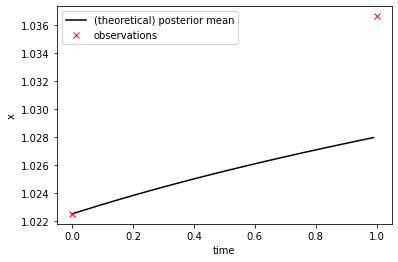

In [50]:
plt.plot(true_sde_pts[:100], compute_mean(true_sde_pts)[:100], color='black', label="(theoretical) posterior mean")
plt.plot(true_sde_pts[::100][:2], obs[:2], 'rx', label='observations')
plt.legend()
plt.xlabel("time")
plt.ylabel("x")
plt.show()

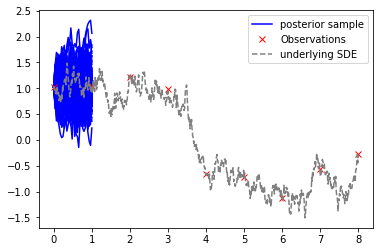

In [51]:
S = 100
posterior = tOU_vector(t0 = obs_time[0], t1 = obs_time[1], z0 = m0[0].repeat(S, 1), m0 = m0[0].repeat(S, 1), alpha = alpha_, beta = beta_, sigma = 1, r = r_, D = S, dN = 30, timegrid='True')
plt.plot(posterior.pts.T, posterior.trj.T, 'b')
plt.plot(posterior.pts.T[0], posterior.trj.T[0], 'b', label="posterior sample")
plt.plot(obs_time, obs, 'rx', label='Observations')
plt.plot(true_sde_pts,true_sde_trj, 'grey', linestyle='dashed', label="underlying SDE")
plt.legend()
plt.show()

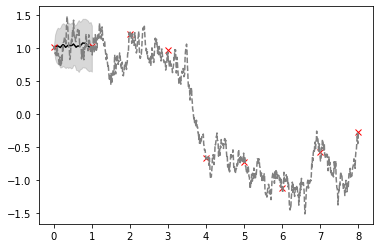

In [52]:
post_mean = torch.mean(posterior.trj, axis=0)
post_std = torch.std(posterior.trj, axis=0)

plt.plot(posterior.pts[0], post_mean, color='black')
plt.fill_between(posterior.pts[0], post_mean + post_std, post_mean - post_std, color='grey', alpha=0.3)
plt.plot(obs_time, obs, 'rx')
plt.plot(true_sde_pts,true_sde_trj, 'grey', linestyle='dashed')

**Trace plot: parameters**

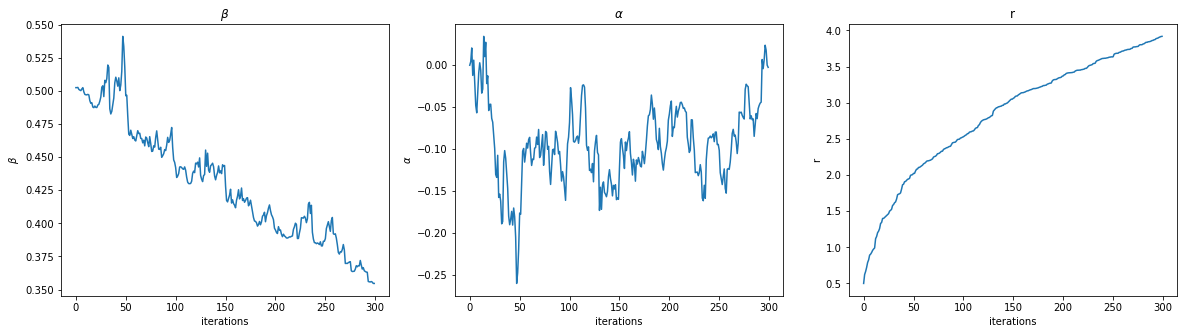

In [53]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
names = [r'$\beta$', r'$\alpha$', 'r']
for i, ax in enumerate(ax.ravel()):
    par = [item[i].data.numpy() for item in trace_pars]
    ax.plot(np.arange(len(par)), par)
    ax.set_title(names[i])
    ax.set_xlabel('iterations')
    ax.set_ylabel(names[i])
# plt.title("Trace plot: beta")
# plt.plot(np.arange(len(betas)), betas)
# plt.xlabel("iteration")
# plt.ylabel(r"$\beta$")
# plt.show()

**Trace plot: ELBO**

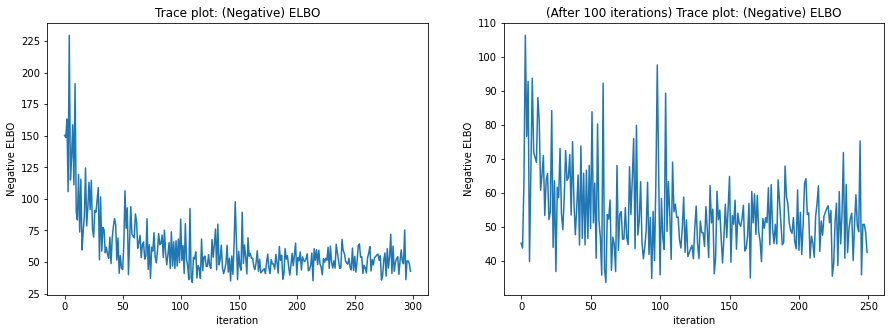

In [54]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

for i, ax in enumerate(ax.ravel()):
    ax.set_title("Trace plot: (Negative) ELBO")
    if i == 0:
        ax.plot(np.arange(len(trace_elbo[1:])), trace_elbo[1:])
    else:
        ax.plot(np.arange(len(trace_elbo[50:])), trace_elbo[50:])
        ax.set_title("(After 100 iterations) Trace plot: (Negative) ELBO")
    ax.set_xlabel("iteration")
    ax.set_ylabel("Negative ELBO")
plt.show()

**Posterior credible interval (constructed by monte carlo estimator based on sample from time-depenent OU with fitted variational parameters**

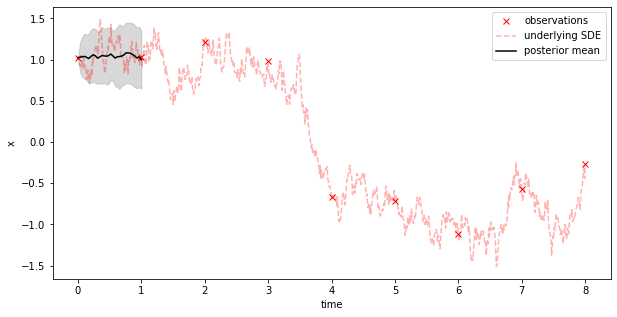

In [55]:
plt.figure(figsize=(10, 5))
plt.plot(obs_time, obs, 'rx', label="observations")
plt.plot(true_sde_pts,true_sde_trj, 'red', linestyle='dashed', alpha= 0.3, label='underlying SDE')
plt.plot(posterior.pts[0], post_mean, color='black', label="posterior mean")
plt.fill_between(posterior.pts[0], post_mean - post_std, post_mean + post_std, color='grey', alpha=0.3)
plt.legend()
plt.xlabel("time")
plt.ylabel("x")
plt.show()

In [33]:
D = 80
S = 50
learning_rate = 0.0005
lr = learning_rate
IT = 400
z0 = obs[0]

vp_mean = []
vp_std = []
vp_pts = []

elbo_traces = np.empty((len(obs_time) - 1, IT))
KL_traces = np.empty((len(obs_time) -1 , IT))
NLL_traces = np.empty((len(obs_time) -1 , IT))
pars_traces = np.empty((3, len(obs_time) - 1, IT))

for t in tq.tqdm(range(obs.shape[0]-1)):
    # initilize a set of parameters
    alpha_ = torch.tensor([0.])
    beta_ = torch.rand(1)
    r_ = torch.rand(1)
    i = 0
    conv = 1
    while (conv > 0.00005) and (i < IT): 
#         print("after z0 = ", z0)
        old = alpha_ + beta_ + r_
        
        alpha_D = alpha_.repeat(D, 1)
        beta_D = beta_.repeat(D, 1)
        r_D = r_.repeat(D, 1)
        z0_D = z0.repeat(D, 1)
        # Compute (negative) ELBO
        vi_ = tOU_vector(t0=obs_time[t], t1=obs_time[t+1], z0=z0_D, m0=z0_D, alpha=alpha_D, beta=beta_D, sigma=sde_sigma, r=r_D, dN=40, D=D, timegrid = 'False')
        elbo_ = ELBO(vi_)
        kl_ = elbo_.KL_ito() + elbo_.KL_rest()
        NLL_ = elbo_.log_prob(obs[t+1].repeat(D, 1), obs_sigma)
        elbo_estimate = -1 * (kl_ + NLL_)
        
        
        elbo_traces[t, i] = torch.mean(elbo_estimate).clone()
        KL_traces[t, i] = torch.mean(kl_).clone()
        NLL_traces[t, i] = torch.mean(NLL_).clone()
        
        # Obtain score function estimator of the gradient
        vi = tOU_vector(t0=obs_time[t], t1=obs_time[t+1], z0=z0_D, m0=z0_D, alpha=alpha_D, beta=beta_D, sigma=sde_sigma, r=r_D, dN=40, D=D, timegrid = 'False')
        elbo = ELBO(vi)
        score = Score(vi)

        scores = score.compute_score(alpha_D, beta_D, z0_D, r_D)
#         print("scores = ", scores)
        f_of_X = -1 * (elbo.log_prob(obs[t+1].repeat(D, 1), obs_sigma) + elbo.KL_ito() + elbo.KL_rest())
#         print("Ito = ", elbo.KL_ito(), "Rest = ", elbo.KL_rest(), "LL = ", elbo.log_prob(torch.tensor(obs[1]).repeat(D, 1)))

        beta_grad = torch.nanmean(f_of_X * scores['beta'])
        alpha_grad = torch.nanmean(f_of_X * scores['alpha'])
        r_grad = torch.nanmean(f_of_X * scores['r'])

        # Update the parameter
        beta_ -= learning_rate * beta_grad
        alpha_ -= learning_rate * alpha_grad
        r__ = r_ - learning_rate * r_grad

#             It is to ensure r should be strictly positive (i.e. projected gradient method)
        while r__ < 0:
            r__ = r_ - lr * r_grad
            lr *= 0.5
        r_ = r__

        pars_traces[0, t, i] = alpha_.clone()
        pars_traces[1, t, i] = beta_.clone()
        pars_traces[2, t, i] = r_.clone()

        new = alpha_.clone() + beta_.clone() + r_.clone()
#         conv = abs(old - new)
        i += 1
        if i % 50 == 0:
            print("alpha = ", alpha_.data.numpy(), "beta = ", beta_.data.numpy(), "r = ", r_.data.numpy(), "(Neg) elbo = ", torch.nanmean(elbo_estimate).data.numpy())
#     print("z0 = ", z0)
    
#     Compute posteiror mean (based on posterior sample)
    posterior = tOU_vector(t0 = obs_time[t], t1 = obs_time[t+1], z0 = z0.repeat(S, 1), m0 = z0.repeat(S, 1), alpha = alpha_, beta = beta_, sigma = sde_sigma, r = r_, D = S, dN = 30, timegrid='True')
    
    
    if t > 0:
        post_mean_ = posterior.trj.mean(axis=0)[1:]
        post_std_ = posterior.trj.std(axis=0)[1:]
        post_pts_ = posterior.pts.mean(axis=0)[1:]
    else:
        post_mean_ = posterior.trj.mean(axis=0)
        post_std_ = posterior.trj.std(axis=0)
        post_pts_ = posterior.pts.mean(axis=0)
    
    vp_mean.append(post_mean_.clone().data.numpy())
    vp_std.append(post_std_.clone().data.numpy())
    vp_pts.append(post_pts_.clone().data.numpy())
#     z0 = torch.tensor(obs[t+1])
    z0 = post_mean_.clone()[-1]
#     print("posterior_mean = ", z0)
# score.compute_score()

  0%|                                                     | 0/8 [00:00<?, ?it/s]

alpha =  [-0.19248064] beta =  [0.47751707] r =  [1.9641986] (Neg) elbo =  79.67370193635409
alpha =  [-0.1755564] beta =  [0.45692068] r =  [2.522687] (Neg) elbo =  45.10653441079898
alpha =  [-0.01069676] beta =  [0.4067503] r =  [2.9867897] (Neg) elbo =  56.77487515963522
alpha =  [-0.05884946] beta =  [0.40447056] r =  [3.3160353] (Neg) elbo =  41.64470515876606
alpha =  [-0.03917196] beta =  [0.388097] r =  [3.6390789] (Neg) elbo =  52.860458693905684
alpha =  [-0.09980538] beta =  [0.39454597] r =  [3.8589816] (Neg) elbo =  52.96086925934709
alpha =  [-0.07840377] beta =  [0.38230467] r =  [4.082225] (Neg) elbo =  46.83843188866028


 12%|█████▋                                       | 1/8 [00:17<02:02, 17.54s/it]

alpha =  [-0.09464221] beta =  [0.38088122] r =  [4.262246] (Neg) elbo =  54.262253869059904
alpha =  [0.24994525] beta =  [0.6063238] r =  [2.061676] (Neg) elbo =  68.14373407181805
alpha =  [0.20437436] beta =  [0.52946424] r =  [2.775063] (Neg) elbo =  62.854145145443724
alpha =  [0.2951543] beta =  [0.54206693] r =  [3.1794336] (Neg) elbo =  66.28305920884443
alpha =  [0.29616398] beta =  [0.5279164] r =  [3.5106928] (Neg) elbo =  60.881205217449995
alpha =  [0.24111606] beta =  [0.46682748] r =  [3.809881] (Neg) elbo =  60.50498199573515
alpha =  [0.25130704] beta =  [0.45472062] r =  [4.03948] (Neg) elbo =  59.55265422098707
alpha =  [0.27971894] beta =  [0.46559906] r =  [4.2757416] (Neg) elbo =  62.10672327053419


 25%|███████████▎                                 | 2/8 [00:35<01:46, 17.71s/it]

alpha =  [0.2578202] beta =  [0.43939522] r =  [4.462136] (Neg) elbo =  64.38478715592399
alpha =  [-0.20204726] beta =  [0.54376537] r =  [1.8966937] (Neg) elbo =  57.336068670452775
alpha =  [-0.11091178] beta =  [0.40693066] r =  [2.4880595] (Neg) elbo =  52.23639082365888
alpha =  [-0.06060442] beta =  [0.33735412] r =  [2.970284] (Neg) elbo =  57.22886366899989
alpha =  [-0.12483107] beta =  [0.33192804] r =  [3.2750473] (Neg) elbo =  49.883334827157015
alpha =  [-0.15571573] beta =  [0.33016986] r =  [3.553821] (Neg) elbo =  50.18775528899421
alpha =  [-0.16697718] beta =  [0.31312284] r =  [3.7712932] (Neg) elbo =  52.886242175842725
alpha =  [-0.20211448] beta =  [0.31693575] r =  [3.9838598] (Neg) elbo =  51.60079678979673


 38%|████████████████▉                            | 3/8 [00:53<01:28, 17.80s/it]

alpha =  [-0.20227395] beta =  [0.2999578] r =  [4.161168] (Neg) elbo =  50.8611837989906
alpha =  [-11.294172] beta =  [-45.065178] r =  [0.11518179] (Neg) elbo =  3442.614777858134
alpha =  [-4.546065] beta =  [-45.065178] r =  [0.11518179] (Neg) elbo =  1938.7766227147251
alpha =  [-0.6486376] beta =  [-45.065178] r =  [0.11518179] (Neg) elbo =  1229.1649287321286
alpha =  [1.8809627] beta =  [-45.065178] r =  [1.9562391] (Neg) elbo =  54.278196629522334
alpha =  [1.7698708] beta =  [-45.065178] r =  [2.4513428] (Neg) elbo =  43.36741656946587
alpha =  [1.7404492] beta =  [-45.065178] r =  [2.837771] (Neg) elbo =  63.10258725677695
alpha =  [1.6667818] beta =  [-45.065178] r =  [3.133376] (Neg) elbo =  54.45480116252382


 50%|██████████████████████▌                      | 4/8 [01:10<01:11, 17.76s/it]

alpha =  [1.6162792] beta =  [-45.065178] r =  [3.4117706] (Neg) elbo =  49.78559854376054
alpha =  [-0.14144792] beta =  [0.19778177] r =  [1.829097] (Neg) elbo =  49.594773813051276
alpha =  [-0.1292663] beta =  [0.17328942] r =  [2.3900697] (Neg) elbo =  40.55629638281482
alpha =  [-0.18467148] beta =  [0.21977744] r =  [2.8060062] (Neg) elbo =  46.45341519144551
alpha =  [-0.24246252] beta =  [0.274837] r =  [3.1085727] (Neg) elbo =  39.546762332892875
alpha =  [-0.20859529] beta =  [0.2319869] r =  [3.335762] (Neg) elbo =  38.2475186089423
alpha =  [-0.21206474] beta =  [0.23264313] r =  [3.5760987] (Neg) elbo =  32.88644045723163
alpha =  [-0.19172685] beta =  [0.20482975] r =  [3.7747164] (Neg) elbo =  36.56537796771537


 62%|████████████████████████████▏                | 5/8 [01:28<00:53, 17.67s/it]

alpha =  [-0.22979566] beta =  [0.24669842] r =  [3.937492] (Neg) elbo =  32.84712825370235
alpha =  [-0.28690588] beta =  [0.32227784] r =  [2.0023546] (Neg) elbo =  65.60837052890574
alpha =  [-0.3242935] beta =  [0.35054493] r =  [2.5884972] (Neg) elbo =  54.33599134957245
alpha =  [-0.28336006] beta =  [0.28724608] r =  [3.031425] (Neg) elbo =  47.712143971683396
alpha =  [-0.3122392] beta =  [0.32071298] r =  [3.3238575] (Neg) elbo =  53.92401493631
alpha =  [-0.2913528] beta =  [0.2924525] r =  [3.5811627] (Neg) elbo =  52.26254627123039
alpha =  [-0.31767735] beta =  [0.32086208] r =  [3.8639472] (Neg) elbo =  49.401743200845054
alpha =  [-0.28773022] beta =  [0.27927774] r =  [4.0488944] (Neg) elbo =  55.211688382448095


 75%|█████████████████████████████████▊           | 6/8 [01:46<00:35, 17.67s/it]

alpha =  [-0.25802207] beta =  [0.24484968] r =  [4.2459464] (Neg) elbo =  66.71510893744687
alpha =  [-0.66963965] beta =  [-0.5446599] r =  [1.9200772] (Neg) elbo =  64.07677088192595
alpha =  [-0.7260436] beta =  [-0.5850758] r =  [2.4579313] (Neg) elbo =  38.572876201434745
alpha =  [-0.6668365] beta =  [-0.5499883] r =  [2.7726457] (Neg) elbo =  43.40783202115778
alpha =  [-0.659486] beta =  [-0.5479396] r =  [3.0574837] (Neg) elbo =  42.60521835150994
alpha =  [-0.6132029] beta =  [-0.519555] r =  [3.3084471] (Neg) elbo =  30.79167161146076
alpha =  [-0.595301] beta =  [-0.5105676] r =  [3.5306501] (Neg) elbo =  36.51624378023204
alpha =  [-0.62254757] beta =  [-0.52966416] r =  [3.70775] (Neg) elbo =  39.909590242864894


 88%|███████████████████████████████████████▍     | 7/8 [02:03<00:17, 17.69s/it]

alpha =  [-0.62031084] beta =  [-0.5287498] r =  [3.8848681] (Neg) elbo =  28.558620496074553
alpha =  [0.31123313] beta =  [0.34350622] r =  [1.7919505] (Neg) elbo =  54.32857937931631
alpha =  [0.30517748] beta =  [0.29966277] r =  [2.3521674] (Neg) elbo =  60.55118155278492
alpha =  [0.34484103] beta =  [0.34683758] r =  [2.7234511] (Neg) elbo =  41.400375094028064
alpha =  [0.35093686] beta =  [0.35514772] r =  [3.053742] (Neg) elbo =  33.039888779485814
alpha =  [0.34076482] beta =  [0.33661044] r =  [3.3382313] (Neg) elbo =  36.917569952513325
alpha =  [0.3294588] beta =  [0.31981543] r =  [3.5452142] (Neg) elbo =  34.004095425729446
alpha =  [0.3297022] beta =  [0.31841856] r =  [3.7353613] (Neg) elbo =  35.38645560493654


100%|█████████████████████████████████████████████| 8/8 [02:21<00:00, 17.71s/it]

alpha =  [0.35061887] beta =  [0.35154158] r =  [3.891049] (Neg) elbo =  28.589505736585522


Trace plot: ELBO

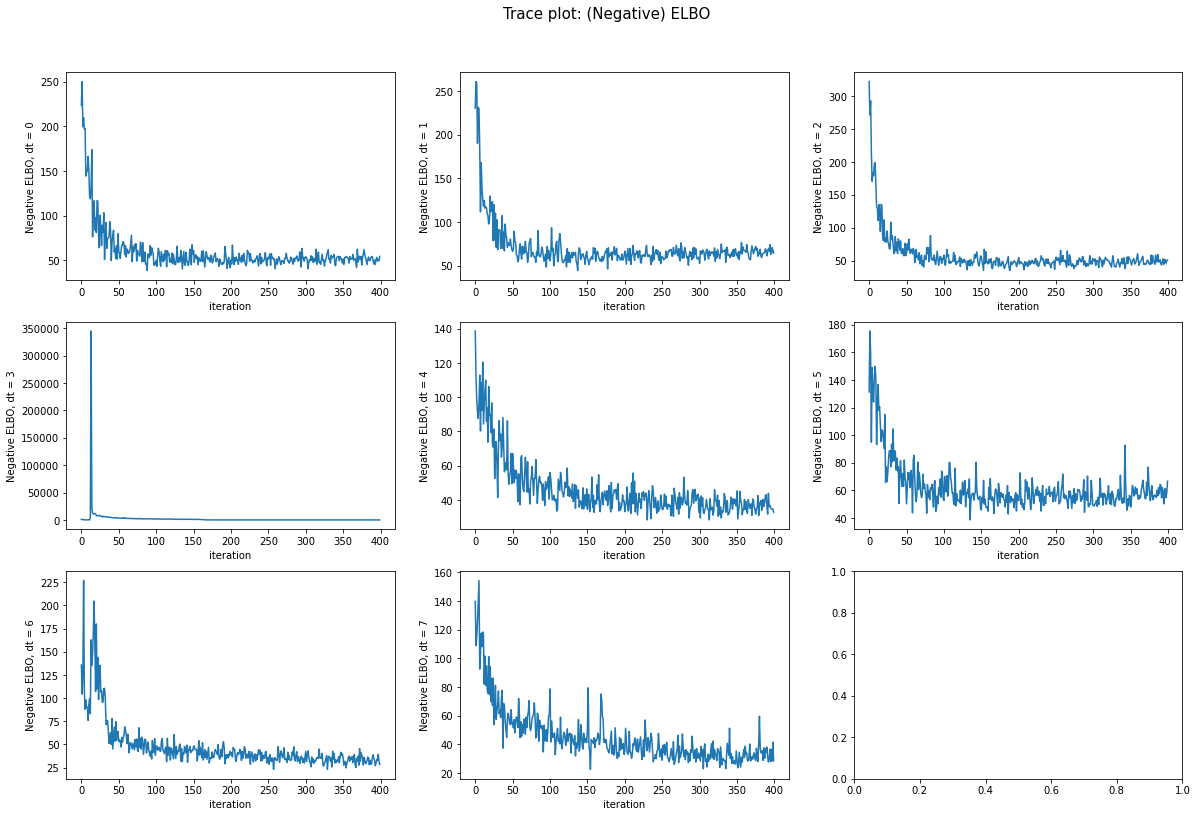

In [73]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 13))
t = 0
for ax in ax.ravel()[:-1]:
    ax.plot(np.arange(len(elbo_traces[t, :])), elbo_traces[t, :])
    ax.set_xlabel("iteration")
    ax.set_ylabel("Negative ELBO, dt = %d" % t)
    t += 1
    
plt.suptitle("Trace plot: (Negative) ELBO", size=15, y=0.95)
plt.show()

Trace plot: KL divergence

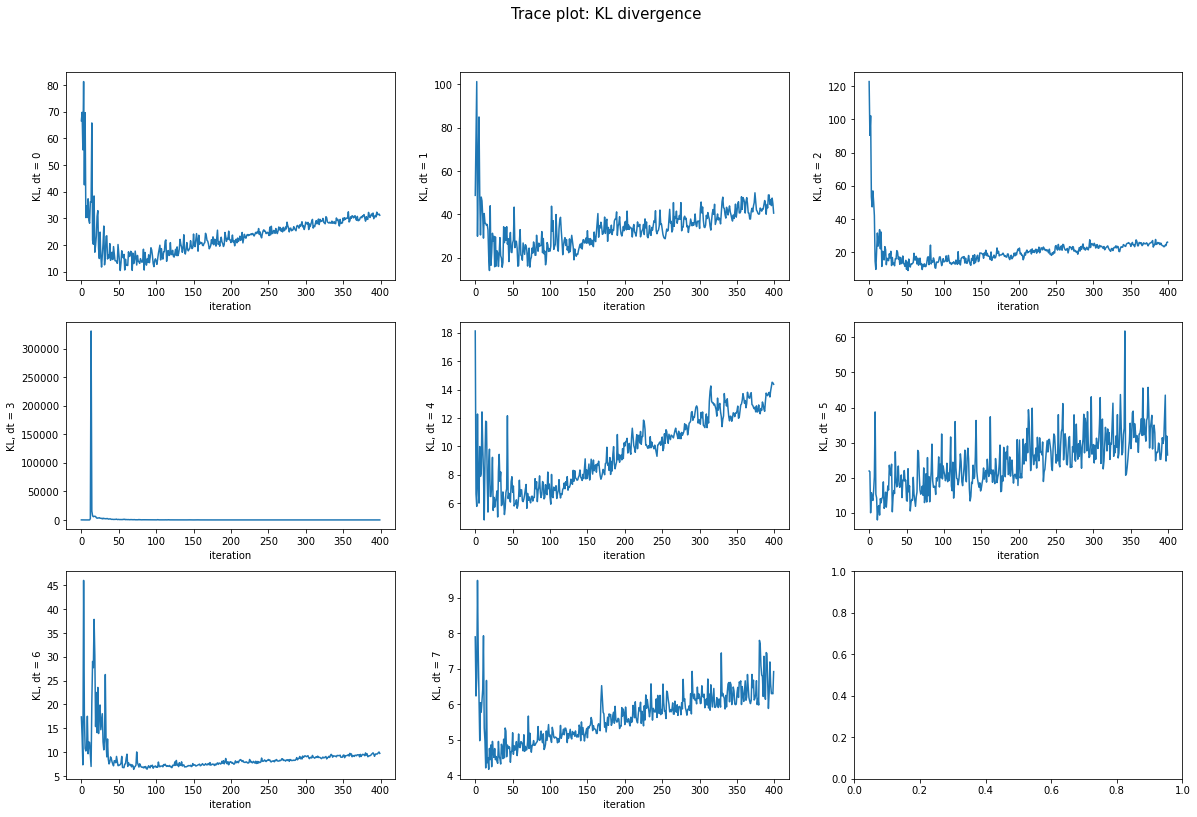

In [72]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 13))
t = 0
for ax in ax.ravel()[:-1]:
    ax.plot(np.arange(len(KL_traces[t, :])), -1 * KL_traces[t, :])
    ax.set_xlabel("iteration")
    ax.set_ylabel("KL, dt = %d" % t)
    t += 1
    
plt.suptitle("Trace plot: KL divergence", size=15, y=0.95)
plt.show()

Trace plot: NLL

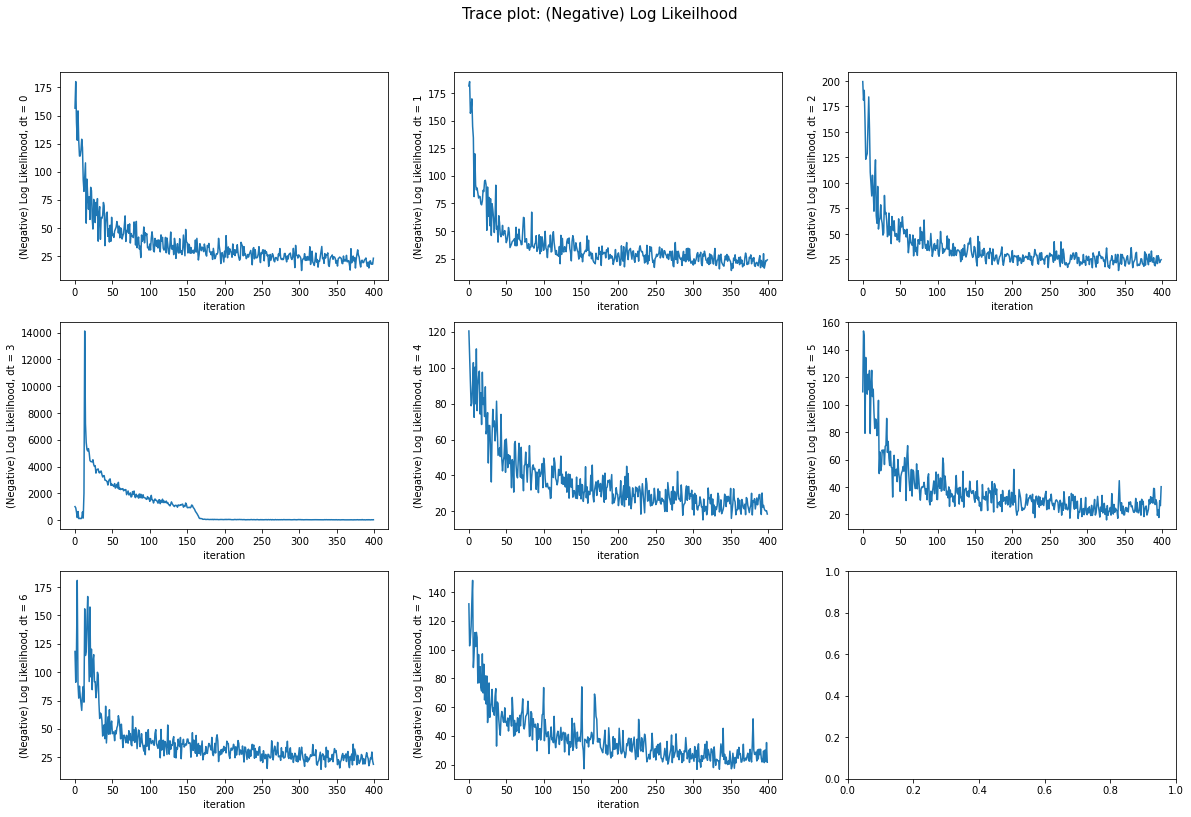

In [66]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 13))
t = 0
for ax in ax.ravel()[:-1]:
    ax.plot(np.arange(len(NLL_traces[t, :])), -1 * NLL_traces[t, :])
    ax.set_xlabel("iteration")
    ax.set_ylabel("(Negative) Log Likelihood, dt = %d" % t)
    t += 1
    
plt.suptitle("Trace plot: (Negative) Log Likeilhood", size=15, y=0.95)
plt.show()

Trace plot: parameters

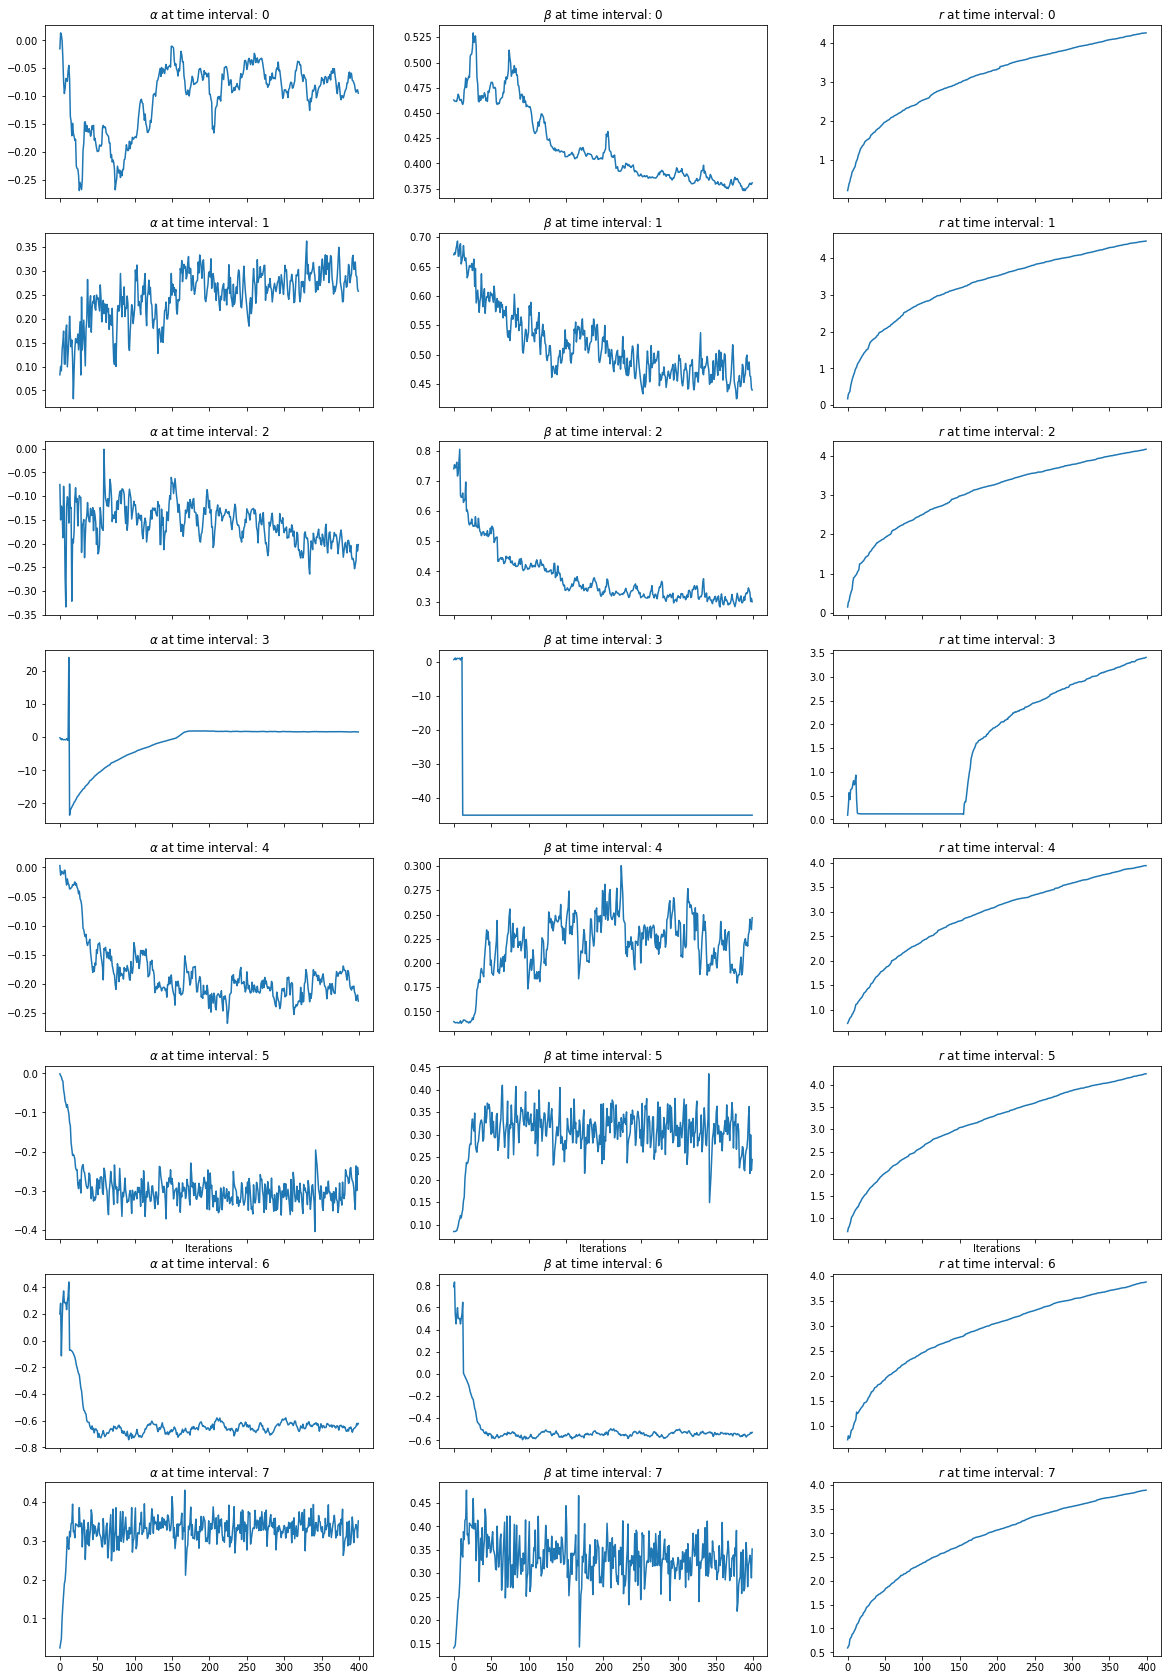

In [37]:
fig, ax = plt.subplots(nrows=pars_traces.shape[1], ncols=3, figsize=(20, 30), sharex='all')
names = [r'$\alpha$', r'$\beta$', r'$r$']
for j, ax in enumerate(ax.ravel()):
    i = j % 3
    t = j // 3
    ax.plot(np.arange(pars_traces[i, t, :].shape[0]), pars_traces[i, t, :])
    ax.set_title(names[i] + " at time interval: %d" % t)
    if t == 5:
        ax.set_xlabel("Iterations")
plt.show()

**Posterior approximation**

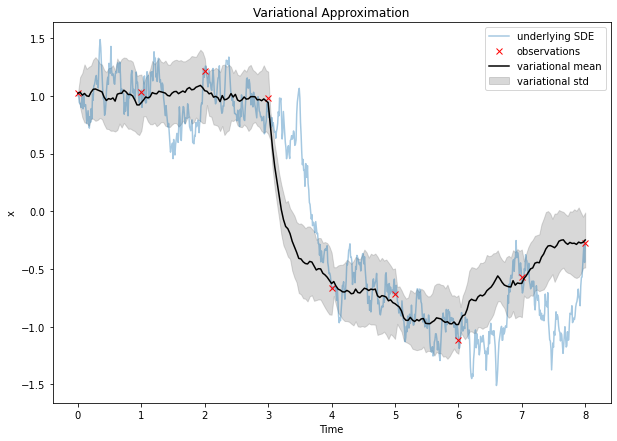

In [75]:
vi_mean = np.concatenate(vp_mean)
vi_var = np.concatenate(vp_std)
vi_pts = np.concatenate(vp_pts)

plt.figure(figsize=(10, 7))
plt.plot(true_sde_pts, true_sde_trj, label="underlying SDE", alpha=0.4)
plt.plot(obs_time, obs, 'rx', label='observations')
plt.plot(np.linspace(0, 8, vi_mean.shape[0]), vi_mean, color='black', label='variational mean')
plt.fill_between(vi_pts, vi_mean + vi_var, vi_mean - vi_var, alpha=0.3, color='grey', label='variational std')
plt.legend()
plt.xlabel("Time")
plt.ylabel("x")
plt.title("Variational Approximation")
plt.show()